In [1]:
from fit.datamodules.tomo_rec import MNIST_TRecFITDM, Kanji_TRecFITDM, LoDoPaB_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram
from fit.transformers.PositionalEncoding2D import PositionalEncoding2D

from matplotlib import pyplot as plt

from skimage.transform import iradon

import torch

import numpy as np

from fit.utils import denormalize_FC, pol2cart, fft_interpolate

# Tomographic Reconstruction Datasets

We used MNIST, Kanji and LoDoPaB in our tomographic reconstruction experiments. This notebook displays the different datasets and allows us to play around with number of projection angles.

Choose a dataset in the next cell.

In [2]:
dm = MNIST_TRecFITDM(root_dir='./data/', batch_size=4, num_angles=7)

# dm = Kanji_TRecFITDM(root_dir='./data/Kanji/', batch_size=4, num_angles=33)

# dm = LoDoPaB_TRecFITDM(batch_size=4, gt_shape=111, num_angles=33)

dm.prepare_data()
dm.setup()

## Filtered Backprojection

Filtered backprojection (FBP) is a common method for tomographic reconstruction.

In [3]:
train_dl = dm.train_dataloader()

for sino, gt  in train_dl.dataset.ds:
    break

In [4]:
fbp = iradon(sino.numpy().T, theta=np.rad2deg(-dm.gt_ds.get_ray_trafo().geometry.angles), circle=True,
                 output_size=dm.gt_shape).astype(np.float32).T

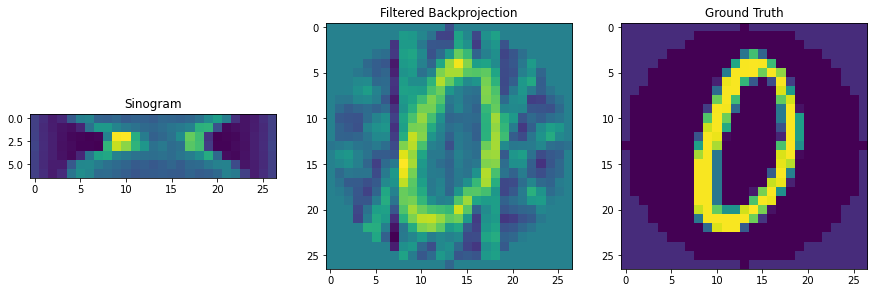

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(sino)
plt.title('Sinogram');
plt.subplot(1,3,2)
plt.imshow(fbp)
plt.title('Filtered Backprojection');
plt.subplot(1,3,3)
plt.imshow(gt)
plt.title('Ground Truth');

Since we only have 7 tilt-angles the FBP sufferes from striping artefacts also known as missing wedge artefacts. These missing wedge artefacts are directly related to an undersampling in Fourier space.

## Fourier Space Sampling

Next we will compute the coordinates of the Fourier transformed projections from the sinogram and compare them to the coordinates of the Fourier transformed ground truth image.

In [6]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [7]:
src_r, src_phi, src_flatten_order = get_polar_rfft_coords_sinogram(angles=dm.gt_ds.get_ray_trafo().geometry.angles,
                                                                   det_len=det_len)
dst_r, dst_phi, dst_flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
target_shape = order.shape

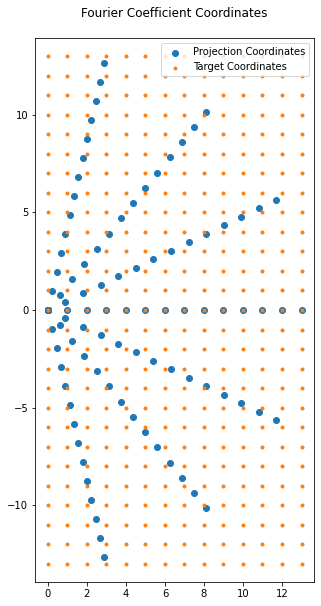

In [8]:
plt.figure(figsize=(5, 10))
plt.scatter(*pol2cart(src_r, src_phi), marker='o', label='Projection Coordinates')
plt.scatter(*pol2cart(dst_r, dst_phi), marker='.', label='Target Coordinates')
plt.legend();
plt.axis('equal');
plt.title('Fourier Coefficient Coordinates\n');

Here we clearly see that many of the high frequencies are not sampled, hence the name missing wedge artefacts.

The goal of our Fourier Image Transformer (FIT) for tomographic reconstruction is to restore these missing high frequency Fourier coefficients.

## Training-Data
In the following cells we inspect the training data and make sure that we can transform the normalized amplitudes and phases of the Fourier transformed sinogram and ground truth back into real image space.

In [9]:
train_dl = dm.train_dataloader()

for sinogram_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in train_dl:
    break

In [10]:
# We have to convert angle and magnitude back to Fourier coefficients
sinogram_fc = denormalize_FC(sinogram_fc, amp_min, amp_max)
y_fc = denormalize_FC(y_fc, amp_min, amp_max)

We already know the we can reconstruct the 2D image from the sinogram via FBP. Here we want to verify that the sinogram Fourier coefficients are valid. We do this by interpolating the Fourier coefficients of the densly sampled Fourier space from `sinogram_fc`.

In [11]:
fc_interpolated = fft_interpolate(src_r, src_phi, dst_r, dst_phi, sinogram_fc[0,src_flatten_order], 
                                   target_shape=target_shape, dst_flatten_order=dst_flatten_order)
rec_interpolated = np.roll(np.fft.irfftn(fc_interpolated, s=2*(dm.gt_shape,)), 2*(dm.gt_shape//2,), (0, 1))

In the next cell we verify that the normalized amplitudes and phases of the ground truth image can be back transformed into real image space i.e. back transformed into the ground truth image.

In [12]:
y_fc_ = y_fc[0].numpy().flatten()[dst_flatten_order]
y_fc_[dst_flatten_order] = y_fc_.flatten()
y_target = np.roll(np.fft.irfftn(y_fc_.reshape(*target_shape), s=2*(dm.gt_shape,)), 2*(dm.gt_shape//2,), (0, 1))

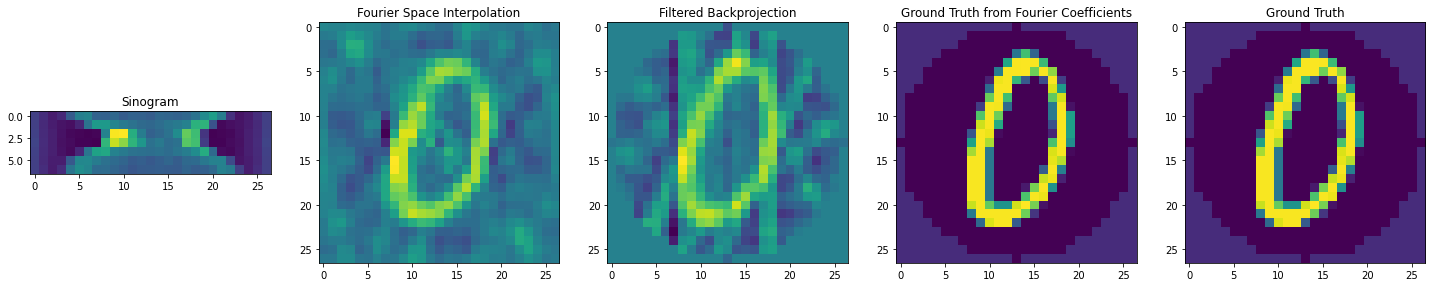

In [13]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(sino)
plt.title('Sinogram');
plt.subplot(1,5,2)
plt.imshow(rec_interpolated)
plt.title('Fourier Space Interpolation');
plt.subplot(1,5,3)
plt.imshow(fbp)
plt.title('Filtered Backprojection')
plt.subplot(1,5,4)
plt.imshow(y_target)
plt.title('Ground Truth from Fourier Coefficients');
plt.subplot(1,5,5)
plt.imshow(y_real[0])
plt.title('Ground Truth');

# Positional Encoding

Since we work with transformers and want to utilize the location information of our data we have to provide it via positional encoding. Fourier spectra are best described by polar-coordinates, hence we use a polar-coordinate based positional encoding.

In [14]:
pos_enc = PositionalEncoding2D(8, (dst_r, dst_phi), dst_flatten_order)

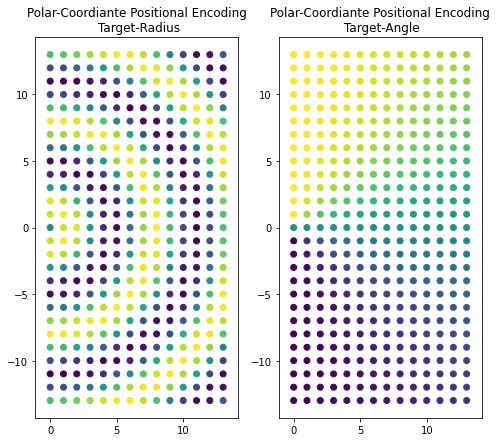

In [15]:
plt.figure(figsize=(8,7))
plt.subplot(1,2,1)
plt.scatter(*pol2cart(dst_r[dst_flatten_order], dst_phi[dst_flatten_order]), c=pos_enc.pe[0,:,0])
plt.axis('equal');
plt.title('Polar-Coordiante Positional Encoding\n Target-Radius');

plt.subplot(1,2,2)
plt.scatter(*pol2cart(dst_r[dst_flatten_order], dst_phi[dst_flatten_order]), c=pos_enc.pe[0,:,4])
plt.axis('equal');
plt.title('Polar-Coordiante Positional Encoding\n Target-Angle');